<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/mlp/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

import sklearn
from sklearn.metrics import adjusted_rand_score

In [2]:
NUM_CENTERS = 4
X, y = sklearn.datasets.make_blobs(n_samples=300, n_features=6, centers=NUM_CENTERS)

In [3]:
# The goal is to utilize kmeans clustering to generate clusters
# Analyze the data -> visually see how many clusters you can identify

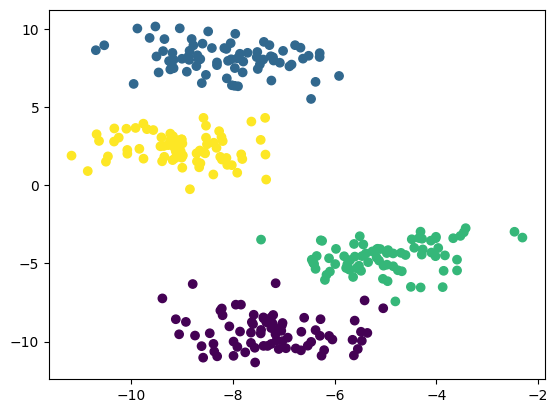

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y) # This is the gold set

In [5]:
def similarity(samples, centroids):

  if isinstance(samples, np.ndarray):
    samples: torch.Tensor = torch.from_numpy(samples)
    centroids: torch.Tensor = torch.from_numpy(centroids)

  samples /= samples.norm(p=2, dim=-1, keepdim=True)
  centroids /= centroids.norm(p=2, dim=-1, keepdim=True)
  return samples @ centroids.t() # batch_size x num_clusters

def run_kmeans_once(samples, centroids: list, num_clusters: int):
  '''
  Initialize cluster centroids.
  Label each sample to the nearest centroid.
  Compute mean centroid position and update the centroid positions
  Repeat
  '''
  num_samples = len(samples)
  if centroids == None:
    random_indices = np.random.choice(num_samples, num_clusters, replace=True)
    centroids = samples[random_indices]

  if isinstance(centroids, np.ndarray):
    centroids = torch.from_numpy(centroids)
  if isinstance(samples, np.ndarray):
    samples = torch.from_numpy(samples)

  sim_matrix = similarity(samples, centroids) # num_samples x num_samples

  labels = torch.zeros(num_samples, num_clusters)
  pos_labels = torch.zeros(num_samples)

  for i in range(num_samples):
    val, idx = torch.topk(sim_matrix[i], k=1)
    # so now we have the index of the most similar sample relative to the cluster position
    # create a one-hot encoded vector
    labels[i, idx] = 1
    pos_labels[i] = idx

  new_centroids = torch.zeros_like(centroids)
  for cluster_id in range(num_clusters):
    sample_idx = torch.where(labels[:, cluster_id] == 1)[0] # these are all the indices that belong to that particular cluster id
    new_centroid = samples[sample_idx].mean(dim=0)
    new_centroids[cluster_id] = new_centroid

  return new_centroids, pos_labels


def run_vectorized_kmeans_once(samples, centroids: list, num_clusters: int):
  '''
  Runs a vectorized version of run_kmeans_once, i.e. no for loops
  samples.shape = batch_size, num_features
  '''
  batch_size = len(samples)
  if centroids == None:
    random_indices = np.random.choice(batch_size, num_clusters, replace=True)
    centroids = samples[random_indices]

  if isinstance(centroids, np.ndarray):
    centroids = torch.from_numpy(centroids)
  if isinstance(samples, np.ndarray):
    samples = torch.from_numpy(samples)

  sim_matrix = similarity(samples, centroids) # batch_size x batch_size
  pos_labels = sim_matrix.argmax(dim=1) # num_samples

  mask = 1 * (pos_labels[None, :] == torch.arange(num_clusters)[:, None]) # num_clusters, batch_size
  masked_samples = torch.einsum("cb,bk->bck", mask, samples) # output shape: batch_size, num_clusters, num_features

  s = masked_samples.sum(dim=0) # num_clusters, num_features
  c = mask.sum(dim=1).view(-1, 1)
  new_centroids = s / c
  return new_centroids, pos_labels


def kmeans(samples, num_clusters, num_iterations, convergence_threshold, run_vectorized: bool):
  centroids = None
  labels = None
  for iter in tqdm(range(num_iterations)):
    if run_vectorized:
      new_centroids, new_labels = run_vectorized_kmeans_once(samples, centroids, num_clusters)
    else:
      new_centroids, new_labels = run_kmeans_once(samples, centroids, num_clusters)

    # We should implement a terminating condition. If the centroid positions shifted by less than 1 norm, then we've more or less converged
    if iter > 1 and torch.norm(new_centroids - centroids, p=2) <= convergence_threshold: # converged
      print(f"\nConverged in {iter} steps with norm: {round(torch.norm(new_centroids - centroids, p=2).item(), 5)}")
      return new_centroids, new_labels

    centroids = new_centroids
    labels = new_labels


  return centroids, labels

In [6]:
unvectorized_centroids, unvectorized_labels = kmeans(X.copy(), NUM_CENTERS, num_iterations=1_000, convergence_threshold=0.1, run_vectorized=False)
vectorized_centroids, vectorized_labels = kmeans(X.copy(), NUM_CENTERS, num_iterations=1_000, convergence_threshold=0.1, run_vectorized=True)

  0%|          | 2/1000 [00:00<00:07, 126.81it/s]


Converged in 2 steps with norm: 0.02227


Cluster accuracy: 1.0


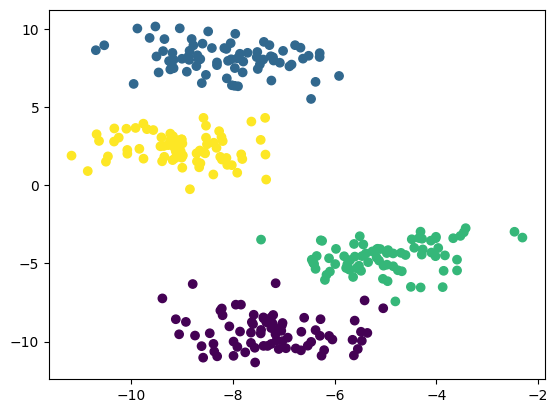

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=vectorized_labels) # Overlay predictions

vectorized_ari = adjusted_rand_score(y, vectorized_labels.cpu().numpy().astype(int)) # measures for similarity among multiple clusters. higher is better
unvectorized_ari = adjusted_rand_score(y, unvectorized_labels.cpu().numpy().astype(int)) # measures for similarity among multiple clusters. higher is better
print(f"Cluster accuracy: {round(vectorized_ari, 3)}")